<a href="https://colab.research.google.com/github/bradsprigg/my-colabs/blob/main/Prompt_Explorer_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prompt Explorer v1.0 by Sathias
Based on Simple Stable 1.2 by @ai_curio

Version History<br>
0.1 Quick and Dirty Version<br>
0.2 Rewrite based on pharmapsychotic notebook<br>
0.3 More configurability options in prompt usage<br>
0.4 Added Prompt Randomizer code by @ai_curio as an extra option<br>
0.5 Updated to include prompt weights and negative prompts<br>
1.0 New prompt creation code and re-written based on Simple Stable 1.2<br>
1.1 Added prompt synonymiser

TO-DO
*   Logging of Prompts
*   SWINIR upsizing
*   Wonderwords integration https://github.com/mrmaxguns/wonderwordsmodule

# License
This program is free software: you can redistribute it and/or modify
it under the terms of the <b>GNU Affero General Public License</b> as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

![2021-12-03 15_31_06-GNU Affero General Public License v3 (AGPL-3.0) Explained in Plain English - TLD.png](https://media.discordapp.net/attachments/837903223867047946/916428453547474944/2021-12-03_15_31_06-GNU_Affero_General_Public_License_v3_AGPL-3.0_Explained_in_Plain_English_-_TLD.png?width=972&height=540)

# Terms of Use

Any unauthorized use of these images for profit, monetary gains, and/or commercial means violates the terms of use of this service. 

If images or their derivatives are presented in a publicly accessible manner in any way, appropriate technological credits ("Created with Simple Stable" or thereabouts) **must** also be provided. If multiple images are created and presented as a group by some means, credit is only required for the group, not each individual image. Credit within a broader "about block" ("Bio", "About the Artist", "Profile", etc.) also fulfills these requirements. 


**Due to the nature of the reconfiguring of images generated by Stable Diffusion, the base of this notebook, this service is not copyright friendly. Use of these generated images from copyrighted material can open you to litigation by the copyright holder(s).**

# Stuff for nerds

In [4]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c715d5ee-355b-f9f4-e637-1302bca689be)


In [11]:
#@title Installation
from IPython.display import display, clear_output
from os.path import exists
import random

!pip install gdown

from google.colab import drive
drive.mount('/content/drive')
outputs_path = "/content/drive/MyDrive/_output" #@param {type:"string"}
!mkdir -p $outputs_path
print(f"Outputs will be saved to {outputs_path}")

!pip install pytorch-lightning==1.7.7 torch-fidelity==0.3.0
!pip install numpy==1.21.6 omegaconf==2.2.3 einops==0.5.0 kornia==0.6.8
!pip install albumentations==1.2.1 transformers==4.21.3 timm==0.4.12 fairscale==0.4.4
!pip install ftfy==6.1.1 jsonmerge==1.8.0 resize-right==0.0.2 torchdiffeq tqdm
!pip install torchsde

!git clone https://github.com/salesforce/BLIP

# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN
# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop
%cd /content

!git clone https://github.com/CompVis/stable-diffusion
%cd stable-diffusion/
!git clone https://github.com/CompVis/taming-transformers
!git clone https://github.com/openai/CLIP.git
!git clone https://github.com/crowsonkb/k-diffusion.git

import sys
sys.path.append(".")
sys.path.append("./CLIP")
sys.path.append('./taming-transformers')
sys.path.append('./k-diffusion')

!echo '' > ./k-diffusion/k_diffusion/__init__.py


import argparse, gc, json, os, random, sys, time, glob, requests
import torch
import torch.nn as nn
import numpy as np
import PIL
from contextlib import contextmanager, nullcontext
from einops import rearrange, repeat
from IPython.display import display, clear_output
from itertools import islice
from omegaconf import OmegaConf
from PIL import Image
from PIL import ImageFilter
from PIL import ImageDraw
from pytorch_lightning import seed_everything
from torch import autocast
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from k_diffusion.sampling import sample_euler_ancestral
from k_diffusion.sampling import sample_lms
from k_diffusion.external import CompVisDenoiser

!rm -rf /content/stable-diffusion/promptexplorer
%cd /content/stable-diffusion
!git clone https://github.com/bradsprigg/promptexplorer
import promptexplorer.promptexplorer as promptexplorer
from promptexplorer.synonymiser import synonymiser

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class config():
    def __init__(self):
        self.ckpt = "/content/sd-weights.ckpt"
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ddim_eta = 0.0
        self.ddim_steps = 100
        self.fixed_code = True
        self.init_img = None
        self.n_iter = 1
        self.n_samples = 1
        self.outdir = ""
        self.precision = 'autocast'
        self.prompt = ""
        self.sampler = 'klms'
        self.scale = 7.5
        self.seed = 42
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
        #upscale stuff
        self.passes = 1
        self.gobig_overlap = 128
        self.detail_steps = 150
        self.upscale_strength = 0.3
        self.detail_scale = 10

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().to(device)
    model.eval()
    return model

def edit_exif_tag_of_image(image_path, tag, value):
    image = Image.open(image_path)
    exif = image.getexif()
    exif[tag] = value
    image.save(image_path, exif=exif)

opt = config()
batch_idx = 0
sample_idx = 0
clear_output(wait=False)

# Choose Your Model

In [6]:
#@title Choose Your Model
#@markdown Each model will take a few minutes to download when you first select it. To change between models, select another model and run this cell again.
#@markdown <br /> If you try to switch models and it doesn't do anything, restart the notebook by Runtime -> Disconnect and Delete Runtime, then Runtime -> Run All
#@markdown
#@markdown `Stable Diffusion 1.4`: Stable Diffusion 1.4 (Default) <br />
#@markdown `Stable Diffusion 1.5`: Stable Diffusion 1.5, requires HuggingFace username and token <br />
#@markdown `Pokemon Diffusion`: Pokemon <br />
#@markdown `Waifu Diffusion`: Anime style <br />
#@markdown `Robo Diffusion`: Robots</p>
%cd /content
model_choice = 'Open Journey' #@param ["Stable Diffusion 1.4","Stable Diffusion 1.5", "Waifu Diffusion", "Pokemon Diffusion", "Robo Diffusion", "Stable Diffusion 1.4 with VAE", "Stable Diffusion 1.5 with VAE", "Open Journey"] {type:"string"}
try_google_drive = True #@param {type:"boolean"}
google_drive_model_location = "/content/drive/MyDrive/_models" #@param {type:"string"}

model_dict = {
    "Stable Diffusion 1.4": {
        "url": "https://huggingface.co/bstddev/sd-v1-4/resolve/main/sd-v1-4.ckpt",
        "filename": "sd-weights-v1-4.ckpt",
        "requires_hf_login": False
    },
    "Stable Diffusion 1.5": {
        "url": "https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned-emaonly.ckpt",
        "filename": "sd-weights-v1-5.ckpt",
        "requires_hf_login": True
    },
    "Pokemon Diffusion": {
        "url": "https://huggingface.co/justinpinkney/pokemon-stable-diffusion/resolve/main/ema-only-epoch%3D000142.ckpt",
        "filename": "pokemon-weights.ckpt",
        "requires_hf_login": False
    },
    "Waifu Diffusion": {
        "url": "https://huggingface.co/hakurei/waifu-diffusion-v1-3/resolve/main/model-epoch05-float16.ckpt",
        "filename": "waifu-weights.ckpt",
        "requires_hf_login": False
    },
    "Robo Diffusion": {
        "url": "https://huggingface.co/nousr/robo-diffusion/resolve/main/models/robo-diffusion-v1.ckpt",
        "filename": "robo-weights.ckpt",
        "requires_hf_login": False
    },
    "Open Journey": {
        "url": "https://huggingface.co/prompthero/openjourney/blob/main/mdjrny-v4.ckpt",
        "filename": "mdjrny-v4.ckpt",
        "requires_hf_login": False
    }
}

current_model = model_dict[model_choice]
model_filename = current_model["filename"]
model_url = current_model["url"]

if exists(f'{google_drive_model_location}/{model_filename}') and try_google_drive and exists(f'/content/{model_filename}') == False:
    print(f"Copying model from Google Drive")
    !cp "{google_drive_model_location}/{model_filename}" /content
elif exists(f'/content/{model_filename}') == False:
  if current_model["requires_hf_login"]:
    print("This model requires an authentication token")
    print("Please ensure you have accepted its terms of service before continuing.")

    username = input("What is your huggingface username?:")
    token = input("What is your huggingface token?:")

    _, path = model_url.split("https://")

    url = f"https://{username}:{token}@{path}"
    # contact server for model
    print(f"Attempting to download {model_choice}...this may take a while")
    ckpt_request = requests.get(url)
    request_status = ckpt_request.status_code

    # inform user of errors
    if request_status == 403:
      raise ConnectionRefusedError("You have not accepted the license for this model.")
    elif request_status == 404:
      raise ConnectionError("Could not make contact with server")
    elif request_status != 200:
      raise ConnectionError(f"Some other error has ocurred - response code: {request_status}")

    with open(f'/content/{model_filename}', 'wb') as model_file:
      model_file.write(ckpt_request.content)
    #!wget -O $model_filename $model_url
  else:
    !wget -O $model_filename $model_url

if exists(f'/content/{model_filename}') == False:
  print("Model download failed, attempting to download default Stable Diffusion:")
  !wget -O sd-weights.ckpt https://huggingface.co/bstddev/sd-v1-4/resolve/main/sd-v1-4.ckpt
  model_filename = "sd-weights.ckpt"

checkpoint_model_file = f'/content/{model_filename}'

# #failsafe
# list_of_ids = ['1tQIdO4MdKnS-0r4YxZgCdF6OflBGQU7p', '1y4WkObHW16prHFjBMv9ZCtgtXPT32bP0', '1qOhc1zyH8S2NQ5oyo0CArSi28ic66lvp', '1omQKzXWf86EW_NMLnCZNuE91wuEP0LMf', '1hgjezfHowXRyj51P6JXEFjy8jUD5Sy_G', '1b4JgE1GkOif6yeKXxeZhG-Duli239kjP', '1Wgi26blHG4sfGupotlOWW3vdtlE1eoIo', '1ONYa73RsIqLNdBJCrTuzOrdqEMdiyE9q', '1NOTqeURhP9K6hvBT-nfpY8sFglaKJUcq', '1MSX5ZL65LVnLcRejEAkN1dztBv83isV9', '1LQ077sgOifoc8d4xomzgSDH0-X7XRFrp', '19H6H0X-TISCbSlwEdGv49c4UDZ_WqkAo', '11J3j0Hia6e_Fi-cyuOnS4Szlre6ELbp_', '1u8-9d2MdbGRhBc3vE5YeMlhsYspgR032', '1tNS7eC0nIuvhWsErd8PlqlhLh7H5l7dX', '1jMSBAfKp-htSlkQ19T2tu2_a-APWzT0t', '11adl7FCYUVOHGxyZf1Z0uJ86gTx7vPE1', '1Ev_DqVs3f0cI8FZDRxuruBBPJIQAQy8G', '1VbsiAM7gPynKrdo5eECLMUpIa3VxibdD', '1lRjLiHAwFXUt4oy_80DIUx1d3XJJq0pU']
# random.shuffle(list_of_ids)
# while exists('/content/sd-v1-4.ckpt') == False and len(list_of_ids) > 0:
#   print("attempting " + list_of_ids[0])
#   !gdown {list_of_ids.pop(0)}

# #Failsafe to CDN
# if exists('/content/sd-v1-4.ckpt') == False:
#   #if random.randint(0, 1) == 0:
#   #  !wget https://bearsharktopus.dev/drilbot_pics/sd-v1-4.ckpt
#   #else:
#   !wget https://bearsharktopus.b-cdn.net/drilbot_pics/sd-v1-4.ckpt
# else:
#   print("Model already downloaded!")

%cd stable-diffusion/
opt.ckpt = checkpoint_model_file
config = OmegaConf.load(f"{opt.config}")
model = load_model_from_config(config, f"{opt.ckpt}")
model = model.to(device)

from tqdm import tqdm, trange

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

"""
grabs all text up to the first occurrence of ':' 
uses the grabbed text as a sub-prompt, and takes the value following ':' as weight
if ':' has no value defined, defaults to 1.0
repeats until no text remaining
"""
def split_weighted_subprompts(text):
    remaining = len(text)
    prompts = []
    weights = []
    while remaining > 0:
        if ":" in text:
            idx = text.index(":") # first occurrence from start
            # grab up to index as sub-prompt
            prompt = text[:idx]
            remaining -= idx
            # remove from main text
            text = text[idx+1:]
            # find value for weight 
            if " " in text:
                idx = text.index(" ") # first occurence
            else: # no space, read to end
                idx = len(text)
            if idx != 0:
                try:
                    weight = float(text[:idx])
                except: # couldn't treat as float
                    print(f"Warning: '{text[:idx]}' is not a value, are you missing a space?")
                    weight = 1.0
            else: # no value found
                weight = 1.0
            # remove from main text
            remaining -= idx
            text = text[idx+1:]
            # append the sub-prompt and its weight
            prompts.append(prompt)
            weights.append(weight)
        else: # no : found
            if len(text) > 0: # there is still text though
                # take remainder as weight 1
                prompts.append(text)
                weights.append(1.0)
            remaining = 0
    return prompts, weights 


class CFGDenoiser(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.inner_model = model

    def forward(self, x, sigma, uncond, cond, cond_scale):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])
        uncond, cond = self.inner_model(x_in, sigma_in, cond=cond_in).chunk(2)
        return uncond + (cond - uncond) * cond_scale

class config():
    def __init__(self):
        self.ckpt = checkpoint_model_file
        self.config = 'configs/stable-diffusion/v1-inference.yaml'
        self.ddim_eta = 0.0
        self.ddim_steps = 100
        self.fixed_code = True
        self.init_img = None
        self.n_iter = 1
        self.n_samples = 1
        self.outdir = ""
        self.precision = 'autocast'
        self.prompt = ""
        self.sampler = 'klms'
        self.scale = 7.5
        self.seed = 42
        self.strength = 0.75 # strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image
        self.H = 512
        self.W = 512
        self.C = 4
        self.f = 8
        #upscale stuff
        self.passes = 1
        self.gobig_overlap = 128
        self.detail_steps = 150
        self.upscale_strength = 0.3
        self.detail_scale = 10
      
def load_img(path, shape):
    if path.startswith('http://') or path.startswith('https://'):
        image = Image.open(requests.get(path, stream=True).raw).convert('RGB')
    else:
        if os.path.isdir(path):
            files = [file for file in os.listdir(path) if file.endswith('.png') or file .endswith('.jpg')]
            path = os.path.join(path, random.choice(files))
            print(f"Chose random init image {path}")
        image = Image.open(path).convert('RGB')
    image = image.resize(shape, resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float16) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.


class BasicSampler():
  def __init__(self):
    ...
  
  def sample(opt, c, uc, shape, scale, steps):
    raise NotImplementedError()

  def sample_img2img(opt, c, uc, shape, init_latent, scale, strength, steps):
    raise NotImplementedError()

class VanillaSampler(BasicSampler):
  def __init__(self, sampler, device):
    self.sampler = sampler
    self.device = device

  def sample(self, opt, c, uc, shape, scale, steps):
    self.sampler.make_schedule(ddim_num_steps=steps, ddim_eta=opt.ddim_eta, verbose=False)
    x_T = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=self.device)
    samples, _ = self.sampler.sample(S=steps,
                                 conditioning=c,
                                 batch_size=opt.n_samples,
                                 shape=shape,
                                 verbose=False,
                                 unconditional_guidance_scale=scale,
                                 unconditional_conditioning=uc,
                                 eta=opt.ddim_eta,
                                 x_T=x_T)
    return samples
     
  def sample_img2img(self, opt, c, uc, shape, init_latent, scale, strength, steps):
    self.sampler.make_schedule(ddim_num_steps=steps, ddim_eta=opt.ddim_eta, verbose=False)
    t_enc = int(strength * steps)
    z_enc = self.sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*opt.n_samples).to(self.device))
    return self.sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale,
                             unconditional_conditioning=uc,)

class KCrowsonSampler(BasicSampler):
  def __init__(self, func, model, device):
    self.func = func
    self.model_wrap = CompVisDenoiser(model)
    self.device = device

  def sample(self, opt, c, uc, shape, scale, steps):
    sigmas = self.model_wrap.get_sigmas(steps)
    model_wrap_cfg = CFGDenoiser(self.model_wrap)
    x_T = torch.randn([opt.n_samples, *shape], device=self.device) * sigmas[0]
    extra_args = {'cond': c, 'uncond': uc, 'cond_scale': scale}
    return self.func(model_wrap_cfg, x_T, sigmas, extra_args=extra_args, disable=False)

  def sample_img2img(self, opt, c, uc, shape, init_latent, scale, strength, steps):
    t_enc = int(strength * steps)
    sigmas = self.model_wrap.get_sigmas(steps)
    sigmas_sched = sigmas[steps - t_enc - 1:]
    model_wrap_cfg = CFGDenoiser(self.model_wrap)
    model_wrap_cfg.init_latent = init_latent
    init_latent += torch.randn([opt.n_samples, *shape], device=device) * sigmas_sched[0]
    extra_args = {'cond': c, 'uncond': uc, 'cond_scale': scale}
    return self.func(model_wrap_cfg, init_latent, sigmas_sched, extra_args=extra_args, disable=False)

sampler_dict = {
    "plms": VanillaSampler(PLMSSampler(model), device),
    "ddim": VanillaSampler(DDIMSampler(model), device),
    "klms": KCrowsonSampler(sample_lms, model, device),
    "euler_a": KCrowsonSampler(sample_euler_ancestral, model, device)
}

#used by txt2img, img2img and sd upscaling
#upscaling uses different scale/strength/steps... and different width/height
def generate_samples(opt, init_latent, scale, strength, steps, shape):
    data = [opt.n_samples * [opt.prompt]]
    precision_scope = autocast if opt.precision == "autocast" else nullcontext
    sampler = sampler_dict[opt.sampler]

    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                for n in range(opt.n_iter):
                    for prompts in data:
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(opt.n_samples * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)

                        # weighted sub-prompts
                        subprompts,weights = split_weighted_subprompts(prompts[0])
                        if len(subprompts) > 1:
                            # i dont know if this is correct.. but it works
                            c = torch.zeros_like(uc)
                            # get total weight for normalizing
                            totalWeight = sum(abs(weight) for weight in weights)
                            # normalize each "sub prompt" and add it
                            for i in range(0,len(subprompts)):
                                weight = weights[i]
                                weight = weight / totalWeight
                                c = torch.add(c,model.get_learned_conditioning(subprompts[i]), alpha=weight)
                        else: # just standard 1 prompt
                            c = model.get_learned_conditioning(prompts)
                        
                        # negative, copy paste
                        # weighted sub-prompts
                        if opt.scale != 1.0 and opt.negative != "":
                            subprompts,weights = split_weighted_subprompts(opt.negative[0])
                            if len(subprompts) > 1:
                                # i dont know if this is correct.. but it works
                                uc = torch.zeros_like(uc)
                                # get total weight for normalizing
                                totalWeight = sum(abs(weight) for weight in weights)
                                # normalize each "sub prompt" and add it
                                for i in range(0,len(subprompts)):
                                    weight = weights[i]
                                    weight = weight / totalWeight
                                    uc = torch.add(uc,model.get_learned_conditioning(subprompts[i]), alpha=weight)
                            else: # just standard 1 prompt
                              uc = model.get_learned_conditioning([opt.negative] * opt.n_samples)

                        if init_latent != None:
                          samples = sampler.sample_img2img(opt, c, uc, shape, init_latent, scale, strength, steps)
                        else:
                          samples = sampler.sample(opt, c, uc, shape, scale, steps)

                        x_samples = model.decode_first_stage(samples)
                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
                        return x_samples

# for txt2img and img2img
def generate(opt):
    global sample_idx
    seed_everything(opt.seed)
    os.makedirs(opt.outdir, exist_ok=True)
  
    batch_size = opt.n_samples
    prompt = opt.prompt
    assert prompt is not None
    init_latent = None

    if opt.init_img != '' and opt.init_img != None:
      if opt.sampler == "plms":
        print ("Sorry! PLMS doesn't work with img2img, switching to DDIM")
        opt.sampler = "ddim"
      print("calling init image")
      init_image = load_img(opt.init_img, shape=(opt.W, opt.H)).to(device)
      init_image = repeat(init_image, '1 ... -> b ...', b=opt.n_samples)
      init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))  # move to latent space

    start_code = None
    if opt.fixed_code and init_latent == None:
        start_code = torch.randn([opt.n_samples, opt.C, opt.H // opt.f, opt.W // opt.f], device=device)

    images = []
    filepaths = []

    shape = [opt.C, opt.H // opt.f, opt.W // opt.f]
    x_samples = generate_samples(opt, init_latent, opt.scale, opt.strength, opt.ddim_steps, shape)

    for x_sample in x_samples:
        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
        images.append(Image.fromarray(x_sample.astype(np.uint8)))
        filepath = os.path.join(opt.outdir, f"{batch_name}({batch_idx})_{sample_idx:04}.png")
        filepaths.append(filepath)
        print(f"Saving to {filepath}")
        Image.fromarray(x_sample.astype(np.uint8)).save(filepath)
        sample_idx += 1
    return images, filepaths

# Upscaling stuff from https://github.com/jquesnelle/txt2imghd
def load_img_for_upscale(img, w, h):
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = img.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

def noisy_ersgan(input: str):
    upscale_folder = "/content/images/ersgan-upscale/"
    escaped_input = shlex.quote(input)
    !python /content/Real-ESRGAN/inference_realesrgan.py -n RealESRGAN_x4plus -i $escaped_input -o $upscale_folder

    output_path = os.path.join(upscale_folder, f"{os.path.splitext(os.path.basename(input))[0]}_out{os.path.splitext(os.path.basename(input))[1]}")
    final_output = Image.open(output_path)
    final_output = final_output.resize((int(final_output.size[0] / 2), int(final_output.size[1] / 2)), Image.LANCZOS)
    return final_output


def realesrgan2x(input: str):
    return deafen(noisy_ersgan, input)

# Upscaling stuff from https://github.com/AUTOMATIC1111/stable-diffusion-webui/blob/master/scripts/sd_upscale.py
import math
from collections import namedtuple
Grid = namedtuple("Grid", ["tiles", "tile_w", "tile_h", "image_w", "image_h", "overlap"])

def split_grid(image, tile_w=512, tile_h=512, overlap=64):
    w = image.width
    h = image.height

    non_overlap_width = tile_w - overlap
    non_overlap_height = tile_h - overlap

    cols = math.ceil((w - overlap) / non_overlap_width)
    rows = math.ceil((h - overlap) / non_overlap_height)

    dx = (w - tile_w) / (cols - 1) if cols > 1 else 0
    dy = (h - tile_h) / (rows - 1) if rows > 1 else 0

    grid = Grid([], tile_w, tile_h, w, h, overlap)
    for row in range(rows):
        row_images = []

        y = int(row * dy)

        if y + tile_h >= h:
            y = h - tile_h

        for col in range(cols):
            x = int(col * dx)

            if x + tile_w >= w:
                x = w - tile_w

            tile = image.crop((x, y, x + tile_w, y + tile_h))

            row_images.append([x, tile_w, tile])

        grid.tiles.append([y, tile_h, row_images])

    return grid

def combine_grid(grid):
    def make_mask_image(r):
        r = r * 255 / grid.overlap
        r = r.astype(np.uint8)
        return Image.fromarray(r, 'L')

    mask_w = make_mask_image(np.arange(grid.overlap, dtype=np.float32).reshape((1, grid.overlap)).repeat(grid.tile_h, axis=0))
    mask_h = make_mask_image(np.arange(grid.overlap, dtype=np.float32).reshape((grid.overlap, 1)).repeat(grid.image_w, axis=1))

    combined_image = Image.new("RGB", (grid.image_w, grid.image_h))
    for y, h, row in grid.tiles:
        combined_row = Image.new("RGB", (grid.image_w, h))
        for x, w, tile in row:
            if x == 0:
                combined_row.paste(tile, (0, 0))
                continue

            combined_row.paste(tile.crop((0, 0, grid.overlap, h)), (x, 0), mask=mask_w)
            combined_row.paste(tile.crop((grid.overlap, 0, w, h)), (x + grid.overlap, 0))

        if y == 0:
            combined_image.paste(combined_row, (0, 0))
            continue

        combined_image.paste(combined_row.crop((0, 0, combined_row.width, grid.overlap)), (0, y), mask=mask_h)
        combined_image.paste(combined_row.crop((0, grid.overlap, combined_row.width, h)), (0, y + grid.overlap))

    return combined_image

# suppress output from one function
import shlex
def deafen(function, *args):
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args)
    sys.stdout = real_stdout
    return output


#upscale
def to_big(filepaths, opt):

    batch_size = opt.n_samples
    prompt = opt.prompt
    assert prompt is not None
    data = [batch_size * [prompt]]
    tile_w = 512
    tile_h = 512
    u_filepaths = []
    u_images = []
    precision_scope = autocast if opt.precision == "autocast" else nullcontext

    for base_filename in filepaths:
        for _ in range(opt.passes):
            filename = os.path.splitext(base_filename)[0]
            
            source_image = realesrgan2x(base_filename)
            og_size = (opt.H,opt.W)
            grid = split_grid(source_image, tile_w=tile_w, tile_h=tile_h, overlap=64)

            work = []

            for y, h, row in grid.tiles:
              for tiledata in row:
                work.append(tiledata[2])

            batch_count = math.ceil(len(work) / batch_size)

            work_results = []
            for i in range(batch_count):
              chunk = work[i*batch_size:(i+1)*batch_size]
              init_image =  load_img_for_upscale(chunk[0], tile_w, tile_h).to(torch.half).to(device)
              init_image = repeat(init_image, '1 ... -> b ...', b=batch_size)
              init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))

              shape = [opt.C, tile_h // opt.f, tile_w // opt.f]
              x_samples = deafen(generate_samples, opt, init_latent, opt.detail_scale, opt.upscale_strength, opt.ddim_steps, shape)

              for x_sample in x_samples:
                  x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                  resultslice = Image.fromarray(x_sample.astype(np.uint8)).convert('RGBA')
                  work_results.append((resultslice.copy()))
              
            image_index = 0
            for y, h, row in grid.tiles:
                for tiledata in row:
                    tiledata[2] = work_results[image_index] if image_index < len(work_results) else Image.new("RGB", (tile_w, tile_h))
                    image_index += 1

            final_output = combine_grid(grid)
            final_output.save(f"{filename}d.png")
        
        filename = f"{filename}_u.png"
        final_output.save(filename)
        u_filepaths.append(filename)
        u_images.append(final_output)

    return u_images, u_filepaths

clear_output(wait=False)

# Image creation

INFO:pytorch_lightning.utilities.seed:Global seed set to 4146461537


Generating: portraits for nicholas caves in szis lawhihi inskis & dsanmerpompeii ), colorfinalfantasy digitalillustrates . cyber deliver c. narvers . synthesiwave. 9 ks . sufi ), lordto my bracelets . trends oncc societies . strangers thing 
Distance: 0.43307929664850237
Minus: indeform . kurating ), happy
Distance: 0.43280736037663053


  0%|          | 0/40 [00:00<?, ?it/s]

Saving to /content/drive/MyDrive/_output/20221211_cavetest/20221211_cavetest(19)_0000.png
Used seed: 4146461537
Saved to: /content/drive/MyDrive/_output/20221211_cavetest


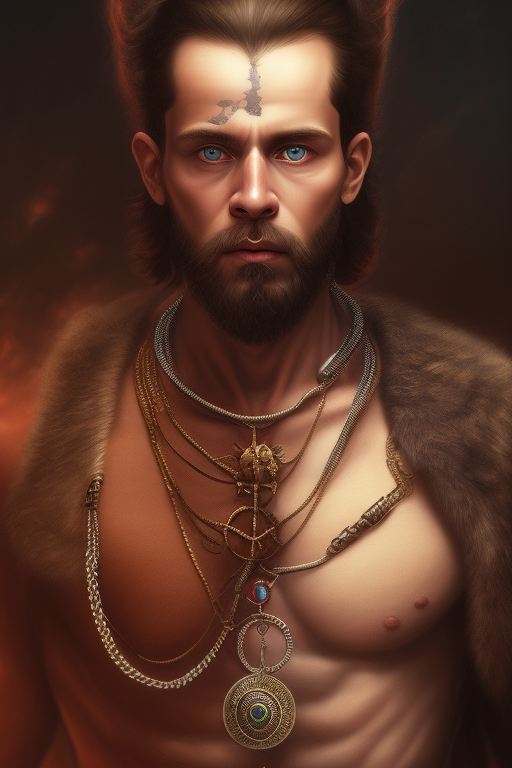

Prompt: portraits for nicholas caves in szis lawhihi inskis & dsanmerpompeii ), colorfinalfantasy digitalillustrates . cyber deliver c. narvers . synthesiwave. 9 ks . sufi ), lordto my bracelets . trends oncc societies . strangers thing 
Negative: indeform . kurating ), happy
Seed: 4146461537


INFO:pytorch_lightning.utilities.seed:Global seed set to 4146461538


Generating: portraits for nicholas cavein szmogaeslaws hihi inskis with qusanta merserbia . colorfinalfantasy portraits ), glowing wave), steampunk . psychedelic els ic. strangers thing . dungeon & dragon . abandisciplinary ), mystical . aarthaary legends 
Distance: 0.4084289460740191
Minus: missshaping ens ), xtra finger. fish
Distance: 0.4248015135526657


  0%|          | 0/40 [00:00<?, ?it/s]

Saving to /content/drive/MyDrive/_output/20221211_cavetest/20221211_cavetest(19)_0001.png
Used seed: 4146461538
Saved to: /content/drive/MyDrive/_output/20221211_cavetest


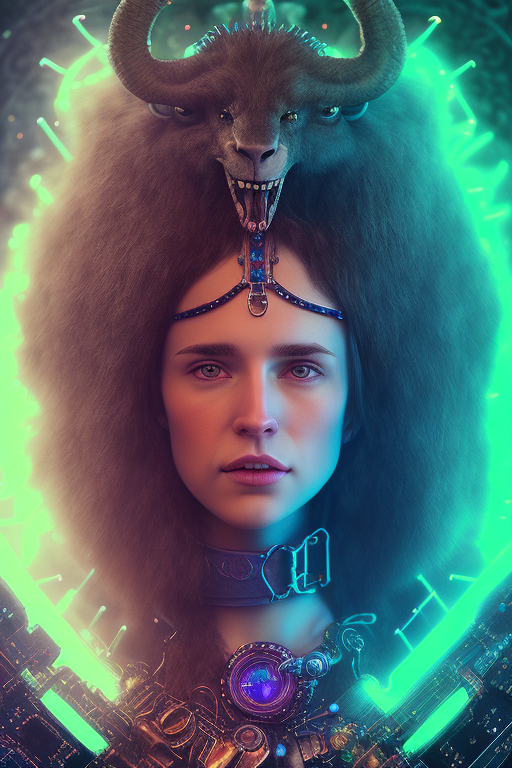

Prompt: portraits for nicholas cavein szmogaeslaws hihi inskis with qusanta merserbia . colorfinalfantasy portraits ), glowing wave), steampunk . psychedelic els ic. strangers thing . dungeon & dragon . abandisciplinary ), mystical . aarthaary legends 
Negative: missshaping ens ), xtra finger. fish
Seed: 4146461538


INFO:pytorch_lightning.utilities.seed:Global seed set to 4146461539


Generating: portraits for nickcaves in z mogaeslaws kvinskis with dsanta merserbia ), colorfantasydigitally illustrates ), cyber prepping ), cyber deliver s . cyber pops ), 7 ks . mystical ), dungeon & dragon.  . folklorethursday 
Distance: 0.4459789352284537
Minus: missin limb ), de forming . happy
Distance: 0.5100834667682648


  0%|          | 0/40 [00:00<?, ?it/s]

Saving to /content/drive/MyDrive/_output/20221211_cavetest/20221211_cavetest(19)_0002.png
Used seed: 4146461539
Saved to: /content/drive/MyDrive/_output/20221211_cavetest


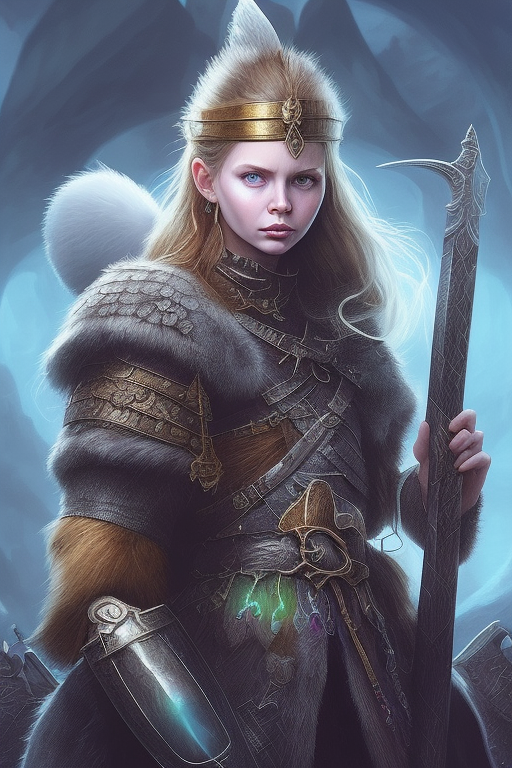

Prompt: portraits for nickcaves in z mogaeslaws kvinskis with dsanta merserbia ), colorfantasydigitally illustrates ), cyber prepping ), cyber deliver s . cyber pops ), 7 ks . mystical ), dungeon & dragon.  . folklorethursday 
Negative: missin limb ), de forming . happy
Seed: 4146461539


INFO:pytorch_lightning.utilities.seed:Global seed set to 4146461540


Generating: portraitfor nicholas cavefrom z eslawhihi inskiing & dsanmar serbia ), colour finalfantasy horrorportraits . steampunk ), cybermonday prepping . outage . expidisciplinary . digitally paint ), creepy y spaghetti . trend ontumblr . nightmares 
Distance: 0.41366841859287684
Minus: missin limb ), bitcoin), extrafinger
Distance: 0.4470967948436737


  0%|          | 0/40 [00:00<?, ?it/s]

Saving to /content/drive/MyDrive/_output/20221211_cavetest/20221211_cavetest(19)_0003.png
Used seed: 4146461540
Saved to: /content/drive/MyDrive/_output/20221211_cavetest


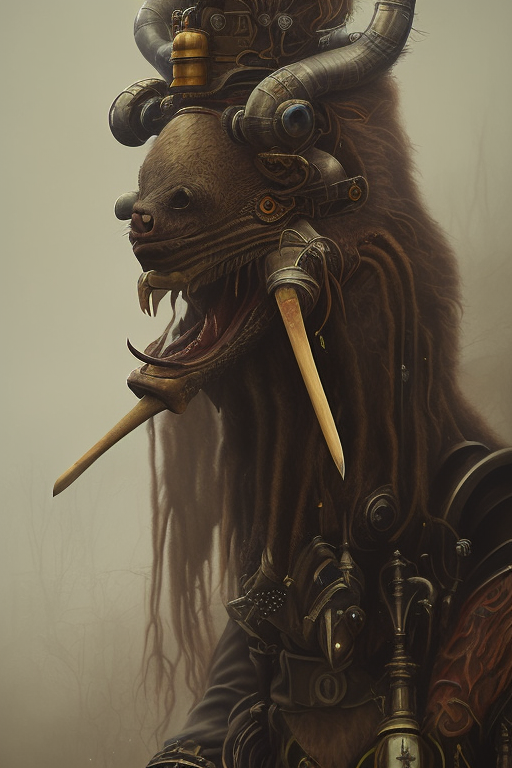

Prompt: portraitfor nicholas cavefrom z eslawhihi inskiing & dsanmar serbia ), colour finalfantasy horrorportraits . steampunk ), cybermonday prepping . outage . expidisciplinary . digitally paint ), creepy y spaghetti . trend ontumblr . nightmares 
Negative: missin limb ), bitcoin), extrafinger
Seed: 4146461540


INFO:pytorch_lightning.utilities.seed:Global seed set to 4146461541


Generating: portraits for nicholas caves from z eslawkvsin skis & qusanmar pompeii ), colorfantasyhorrorportraits . psychedelic el ita . cybermonday gothic . ra vers ), trends in cgi societal . gamefor throne . earthday dawn), darker ), gorgeous 
Distance: 0.42445289467771846
Minus: litecoin ), happy. de forming 
Distance: 0.49422885477542877


  0%|          | 0/40 [00:00<?, ?it/s]

Saving to /content/drive/MyDrive/_output/20221211_cavetest/20221211_cavetest(19)_0004.png
Used seed: 4146461541
Saved to: /content/drive/MyDrive/_output/20221211_cavetest


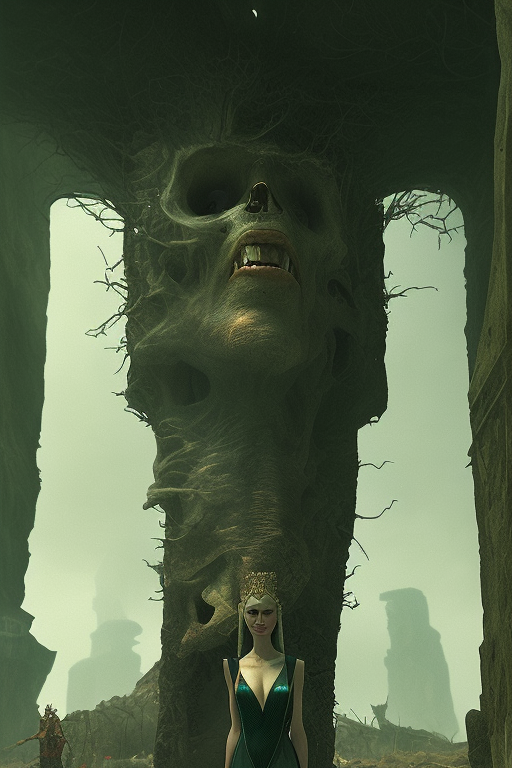

Prompt: portraits for nicholas caves from z eslawkvsin skis & qusanmar pompeii ), colorfantasyhorrorportraits . psychedelic el ita . cybermonday gothic . ra vers ), trends in cgi societal . gamefor throne . earthday dawn), darker ), gorgeous 
Negative: litecoin ), happy. de forming 
Seed: 4146461541


INFO:pytorch_lightning.utilities.seed:Global seed set to 4146461542


Generating: portraitfor nicholas caves in z is laws kvinskis & qusanmar pompeii . colorfantasyportraits . glowing waves ), narve ), cybermonday ), ar thaary legends . folklorethursday . earth dusk . lgsocieties . gamefor throne 
Distance: 0.41983699539433356
Minus: extrafinger), happy), mutant ating 
Distance: 0.44542948263032095


  0%|          | 0/40 [00:00<?, ?it/s]

Saving to /content/drive/MyDrive/_output/20221211_cavetest/20221211_cavetest(19)_0005.png
Used seed: 4146461542
Saved to: /content/drive/MyDrive/_output/20221211_cavetest


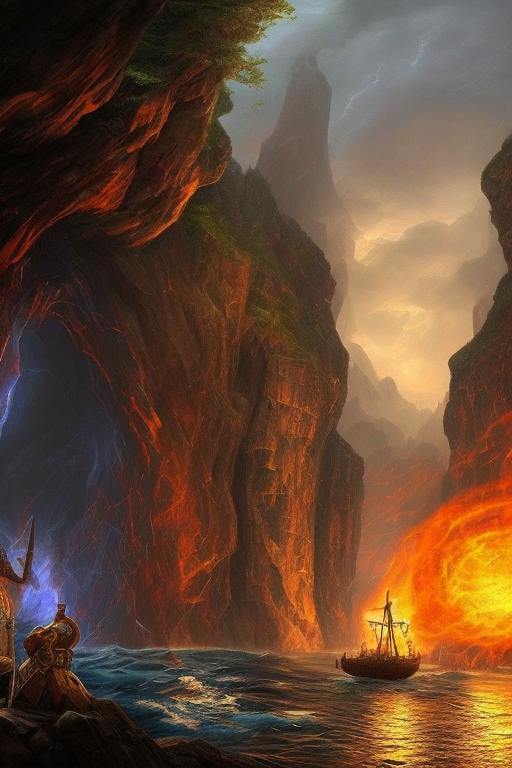

Prompt: portraitfor nicholas caves in z is laws kvinskis & qusanmar pompeii . colorfantasyportraits . glowing waves ), narve ), cybermonday ), ar thaary legends . folklorethursday . earth dusk . lgsocieties . gamefor throne 
Negative: extrafinger), happy), mutant ating 
Seed: 4146461542


INFO:pytorch_lightning.utilities.seed:Global seed set to 4146461543


Generating: portraitto nicholas cavefrom szeslaws kvsin skis with dsanta merpompeii . colour fantasyportraits ), scenes ), glowing waves . schizophel ita . dashing ),  ), earth dawn), creep sypizza ), shy 
Distance: 0.4162540453117947
Minus: fish), de form . dull 
Distance: 0.47130582729975384


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
#!rm -rf /content/images/*
#@title Put your stuff here!
from datetime import datetime
batch_name = "20221211_cavetest" #@param {type:"string"}

#@markdown ---
#@markdown <b>Prompt Explorer Settings</b>
#@markdown ---
COMBINE_METHOD = "Directional" #@param ["No weights", "Directional", "Constant Weights"]
SEGMENTS_1 = "mdjrny-v4 style" #@param {type:"string"}
SEGMENT_COUNT_1 = 0 #@param {type:"slider", min:0, max:5, step:1} 
SEGMENT_WEIGHT_1 = 1.0 #@param {type:"number"}
SEGMENTS_2 = "portrait of Nick Cave by Zdzislaw Beksinski and Dusan Markovic" #@param {type:"string"}
SEGMENT_COUNT_2 = 1 #@param {type:"slider", min:0, max:5, step:1} 
SEGMENT_WEIGHT_2 = 1.0 #@param {type:"number"}
SEGMENTS_3 = "color fantasy portrait, color fantasy horror portrait, color fantasy digital illustration" #@param {type:"string"}
SEGMENT_COUNT_3 = 1 #@param {type:"slider", min:0, max:5, step:1} 
SEGMENT_WEIGHT_3 = 0.3 #@param {type:"number"}
SEGMENTS_4 = "by beeple, by artgerm, by Zdzislaw Beksinski, by HR Giger, by Moebius, by magali villeneuve, by stephan martiniere, by raymond swanland, by ilya kuvshinov, by wlop, by ruan jia, by fenghua zhong, by richard corben, by bruce brenneise, by peter mohrbacher,by beeple, by artgerm, by Zdzislaw Beksinski, by HR Giger, by magali villeneuve, by stephan martiniere, by Dusan Markovic, by Pat Presley, by Jaros\u0142aw Ja\u015Bnikowski, by Peter Gric, by Ross Tran, by Loic Zimmerman, by Tim White, by Wayne Barlowe, by Jim Burns " #@param {type:"string"}
SEGMENT_COUNT_4 = 0 #@param {type:"slider", min:0, max:5, step:1} 
SEGMENT_WEIGHT_4 = 0.6 #@param {type:"number"}
SEGMENTS_5 = "Raver, Cyberdelic, Cybergoth, Cyberpop, Cyberprep, Cyberpunk, Glitch, Glowwave, Psychedelica, Scene, Seapunk, Synthwave" #@param {type:"string"}
SEGMENT_COUNT_5 = 3 #@param {type:"slider", min:0, max:5, step:1} 
SEGMENT_WEIGHT_5 = 0.8 #@param {type:"number"}
SEGMENTS_6 = "nightmare, ominous, occult, creepy, dark, mysterious, creepypasta, digital painting, HDR, 8k, cgsociety, octane engine, elegant, handsome, trending on cg society, trending on artstation, trending on deviantart, reddit, lord of the rings, game of thrones, dungeons and dragons, stranger things, d&d, earthdawn, tolkien, runic, Arthurian legend, fey, abyssal" #@param {type:"string"}
SEGMENT_COUNT_6 = 5 #@param {type:"slider", min:0, max:5, step:1} 
SEGMENT_WEIGHT_6 = 0.5 #@param {type:"number"}
SEGMENTS_7 = "bitcoin, greyscale, happy, boring, fish, mutations, missing limbs, extra fingers, deformed, misshapen, mutated" #@param {type:"string"}
SEGMENT_COUNT_7 = 3 #@param {type:"slider", min:0, max:5, step:1} 
SEGMENT_WEIGHT_7 = -0.5 #@param {type:"number"}
prompt = ""
negative = ""

#@markdown <br>
#@markdown <b>Prompt Synonymiser</b><br>
#@markdown The Prompt Synonymiser will take the generated prompt and use CLIP to randomise the tokens to another one within <i>distance</i>
#@markdown <br>
use_prompt_synonymiser = True #@param {type:"boolean"}
distance = 2 #@param {type:"slider", min:1, max:10, step:1}
#convert distance to integer
distance = int(distance)

#@markdown <br>
#@markdown <b>Image Settings</b><br>
width_height = [512, 768] #@param{type: 'raw'}
#@markdown <br>
steps = 40 #@param {type:"integer"}
samples_per_batch = 1 #@param {type:"integer"}
batches = 100 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
sampler = 'euler_a' #@param ["ddim", "plms", "klms", "euler_a"] {type:"string"}
#batch_name = batch_name + datetime.now().strftime("%H:%M:%S")
guidance_scale = 10 #@param {type:"number"}
ddim_eta = 0.0
zoom = False

#@markdown <br>
#@markdown
#@markdown <b>Init image</b><br>
#@markdown `init_image_or_folder`: url or path to an image, or path to a folder to pick random images from<br>
#@markdown `init_strength`: from 0.0 to 1.0 how much the init image is used<br>
init_image_or_folder = "" #@param {type:"string"}
init_strength = 0.35 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
#@markdown <br>
#@markdown
#@markdown <b>Upscaling</b><br>
#@markdown `upscale_results`: tick this to upscale each image, will take longer to generate <br />
#@markdown `detailing`: controls the upscaling steps, higher is more detailed but takes longer and might introduce weird details <br />
#@markdown `upscale_strength`: like init_strength but for upscaling, 0.7 is default
upscale_results = False #@param {type: 'boolean'}
detailing = 1 #@param {type:"slider", min:1, max:4, step:1}
upscale_strength = 0.7 #@param {type:"slider", min:0.0, max:1.0, step:0.05}

opt.init_img = init_image_or_folder
opt.ddim_steps = steps
opt.n_iter = 1
opt.n_samples = samples_per_batch
opt.outdir = os.path.join(outputs_path, batch_name)
opt.prompt = prompt
opt.negative = negative
opt.sampler = sampler
opt.scale = guidance_scale
opt.seed = random.randint(0, 2**32) if seed == -1 else seed
opt.strength = max(0.0, min(1.0, 1.0 - init_strength))
opt.W, opt.H = map(lambda x: x - x % 64, (width_height[0], width_height[1])) # resize to integer multiple of 64
#upscale stuff
opt.upscale = upscale_results
opt.passes = 1
opt.gobig_overlap = 128
#opt.detail_steps = 150
opt.detail_steps = steps*detailing
opt.upscale_strength = max(0.0, min(1.0, 1.0 - upscale_strength))
opt.detail_scale = 10

if opt.strength >= 1 or init_image_or_folder == None:
    opt.init_img = ""

if opt.sampler != 'ddim':
    opt.ddim_eta = 0.0

# save settings
settings = {
    'ddim_eta': ddim_eta,
    'guidance_scale': guidance_scale,
    'init_image': init_image_or_folder,
    'init_strength': init_strength,
    'num_batch_images': 1,
    'prompt': prompt,
    'sampler': sampler,
    'samples_per_batch': samples_per_batch,
    'seed': opt.seed,
    'steps': steps,
    'width': opt.W,
    'height': opt.H,
}
os.makedirs(opt.outdir, exist_ok=True)
while os.path.isfile(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt"):
    batch_idx += 1
with open(f"{opt.outdir}/{batch_name}({batch_idx})_settings.txt", "w+", encoding="utf-8") as f:
    json.dump(settings, f, ensure_ascii=False, indent=4)
sample_idx = 0

promptFragments = promptexplorer.promptFragments()
promptFragments.clear()
# only add fragments if they are not empty
if SEGMENT_COUNT_1 > 0:
    promptFragments.addFragment(SEGMENTS_1, SEGMENT_COUNT_1, SEGMENT_WEIGHT_1)
if SEGMENT_COUNT_2 > 0:
    promptFragments.addFragment(SEGMENTS_2, SEGMENT_COUNT_2, SEGMENT_WEIGHT_2)
if SEGMENT_COUNT_3 > 0:
    promptFragments.addFragment(SEGMENTS_3, SEGMENT_COUNT_3, SEGMENT_WEIGHT_3)
if SEGMENT_COUNT_4 > 0:
    promptFragments.addFragment(SEGMENTS_4, SEGMENT_COUNT_4, SEGMENT_WEIGHT_4)
if SEGMENT_COUNT_5 > 0:
    promptFragments.addFragment(SEGMENTS_5, SEGMENT_COUNT_5, SEGMENT_WEIGHT_5)
if SEGMENT_COUNT_6 > 0:
    promptFragments.addFragment(SEGMENTS_6, SEGMENT_COUNT_6, SEGMENT_WEIGHT_6)
if SEGMENT_COUNT_7 > 0:
    promptFragments.addFragment(SEGMENTS_7, SEGMENT_COUNT_7, SEGMENT_WEIGHT_7)

hybrid_index = 0

for i in range(batches):
    gc.collect()
    torch.cuda.empty_cache()
    pdist = 0
    ndist = 0
    if COMBINE_METHOD == "No weights":
        prompt = promptFragments.combineFragments(promptexplorer.CombineMethod.SELECT_NUM)
        negative = ""
    if COMBINE_METHOD == "Directional":
        prompt = promptFragments.combineFragments(promptexplorer.CombineMethod.SELECT_NUM_DIRECTIONAL, promptexplorer.Direction.POSITIVE)
        negative = promptFragments.combineFragments(promptexplorer.CombineMethod.SELECT_NUM_DIRECTIONAL, promptexplorer.Direction.NEGATIVE)
    elif COMBINE_METHOD == "Constant Weights":
        prompt = promptFragments.combineFragments(promptexplorer.CombineMethod.SELECT_NUM_WITH_WEIGHT, promptexplorer.Direction.POSITIVE)
        negative = promptFragments.combineFragments(promptexplorer.CombineMethod.SELECT_NUM_WITH_WEIGHT, promptexplorer.Direction.NEGATIVE)
    opt.prompt = prompt
    opt.negative = negative
    if use_prompt_synonymiser:
        syn = synonymiser(prompt, distance)
        prompt, pdist = syn.synonymise()
        opt.prompt = prompt
        syn = synonymiser(negative, distance)
        negative, ndist = syn.synonymise()
        opt.negative = negative
    print(f"Generating: {opt.prompt}")
    if pdist > 0:
        print(f"Distance: {pdist}")
    if opt.negative != "":
        print(f"Minus: {opt.negative}")
        if ndist > 0:
          print(f"Distance: {ndist}")
    images, filepaths = generate(opt)

    print(f"Used seed: {opt.seed}")
    print(f"Saved to: {opt.outdir}")
    if not upscale_results:
      for image in images:
        display(image)
    if upscale_results:    
      print("Upscaling image")
      u_images, u_filepaths = to_big(filepaths, opt)
      print("Upscaled:")
      for image in u_images:
        display(image)
    print(f"Prompt: {opt.prompt}")
    if opt.negative != "":
        print(f"Negative: {opt.negative}")
    print(f"Seed: {opt.seed}")
    
    opt.seed = opt.seed + 1

print("done")